In [2]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from sklearn.utils import shuffle

In [3]:
TF_ENABLE_ONEDNN_OPTS=1
home_dir = os.getenv("home_BA885")

# Assign home_dir as a local directory to use when saving data to disk.

# Feature Engineering

The premise of machine learning is to use abundance of data and computational power to compensate for our lack of understanding and inadequate modeling. This, however, is not always guaranteed to succeed as it is quite common for a large and clean dataset to be absent or for out computational resources to be limited. In practice, a successful ML model lies somewhere on a spectrum that has Large Deep Neural Networks (large hypothesis space) on one end and Exact Mathematical Modeling with a handful of parameters on the other end, which requires making numerous assumptions about the data and its important features.

The main distinction between the two ends of the spectrum is the size of the hypothesis space which has a direct correlation with the number of trainable parameters: the larger the number of parameters, the bigger the hypothesis space and the fewer the number of assumptions we need to make regarding the relevant features in our dataset.

However, as we scale up the number of trainable parameters the model becomes more and more susceptible to overfitting and as the number of trainable parameters approaches the number of training samples this issue becomes harder and harder to mitigate. Furthermore, the larger the model the more resources are required to train and deploy it which may not be desirable, for instance when the deplyed model's response time needs to be minimized.

## A simple binary classification problem

The underlying principle in feature engineering is to gain a deeper understanding of the data. One approach is to train a simple deep neural network and observe its behavior.

Here we will look at a toy example of MNIST restricted to identifying whether the input is an image of the digit 0 or not.

In [36]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Rescale the data
train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255

# Generate new labels that determine whether the digit is 0 or not
# (label = 0 if the digit is 0 and label = 1 otherwise.)
train_labels_0 = train_labels.astype('bool').astype('int')
test_labels_0 = test_labels.astype('bool').astype('int')

In [61]:
# Build a very simple model, we will do this through a function as we will be
# initializing such a model multiple times.
def ZeroOrNot(x = 'mnist_0_model'):
    # Generates a model with input shape (28,28) and output shape (1)
    mnist_0_input = layers.Input(shape=(28,28,))
    mnist_0_flatten = layers.Flatten()(mnist_0_input)
    mnist_0_output = layers.Dense(1, activation="sigmoid")(mnist_0_flatten)
    #
    return keras.Model(inputs = mnist_0_input, outputs = mnist_0_output, name = x)

mnist_0_model = ZeroOrNot('mnist_0_model')
mnist_0_model.summary()

Model: "mnist_0_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_23 (Dense)            (None, 1)                 785       
                                                                 
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________


In [62]:
# Choose the optimizer, loss function and metrics with which to compile the model.
# We will choose binary crossentropy as the loss function since the labels are 0 or 1
# and the model output is a single number between 0 and 1.
optim0 = "rmsprop"
loss0 = "binary_crossentropy"
metrics0 = ["binary_accuracy"]

mnist_0_model.compile(optimizer = optim0, loss = loss0, metrics = metrics0)

In [63]:
# Set history = model.fit in order to store the loss and accuracy of the model after
# each epoch. Utilize early stoppping callback.

callb0 = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',
                                       patience=3,
                                       restore_best_weights=True
                                      )

history = mnist_0_model.fit(train_images, train_labels_0,
                            validation_split = 0.2,
                            epochs = 30,
                            batch_size = 256,
                            callbacks = callb0)

Epoch 1/30
188/188 [==============================] - 1s 5ms/step - loss: 0.1797 - binary_accuracy: 0.9511 - val_loss: 0.0753 - val_binary_accuracy: 0.9808
Epoch 2/30
188/188 [==============================] - 1s 4ms/step - loss: 0.0571 - binary_accuracy: 0.9859 - val_loss: 0.0450 - val_binary_accuracy: 0.9872
Epoch 3/30
188/188 [==============================] - 1s 5ms/step - loss: 0.0409 - binary_accuracy: 0.9893 - val_loss: 0.0365 - val_binary_accuracy: 0.9900
Epoch 4/30
188/188 [==============================] - 1s 4ms/step - loss: 0.0355 - binary_accuracy: 0.9903 - val_loss: 0.0326 - val_binary_accuracy: 0.9910
Epoch 5/30
188/188 [==============================] - 1s 7ms/step - loss: 0.0328 - binary_accuracy: 0.9908 - val_loss: 0.0307 - val_binary_accuracy: 0.9918
Epoch 6/30
188/188 [==============================] - 1s 6ms/step - loss: 0.0311 - binary_accuracy: 0.9910 - val_loss: 0.0294 - val_binary_accuracy: 0.9913
Epoch 7/30
188/188 [==============================] - 1s 4ms/ste

In [64]:
# Evaluate the model on the test dataset. Note that given the distribution of data
# a model that always predicts "not zero" will have binary_accuracy ~ 0.90

mnist_0_model.evaluate(test_images, test_labels_0)

313/313 [==============================] - 0s 883us/step - loss: 0.0232 - binary_accuracy: 0.9929


[0.023230357095599174, 0.992900013923645]

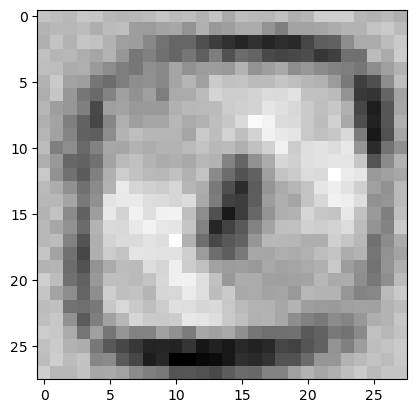

In [65]:
# Lets look at what features the trained model is focusing on
weights = mnist_0_model.layers[2].get_weights()[0]

# Reshape to match the original image shape (28x28)
weights = weights.reshape(28,28)

# Plot the weights, the bright pixels correspond to the pixels the model
# deems important features that help distinguish 0 from other digit images.
plt.imshow(weights, cmap=plt.cm.binary)
plt.show()

It should not come as a surprise that the pixels the model focuses on resemble
the digit 0. In fact if we look at what the average of all the images of the digit 0 looks like we will that it looks pretty similar.

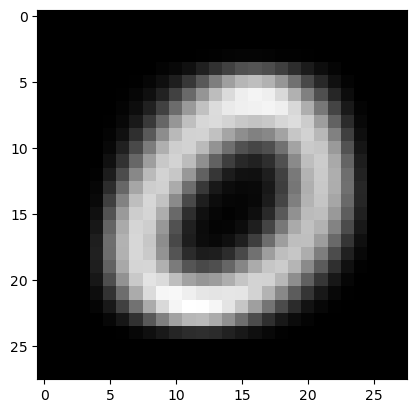

In [66]:
# Take the average of all the images of the digit 0
zero_indices = np.where(train_labels==0)
average_zero_image = np.average(train_images[zero_indices],axis=0)

plt.imshow(1 - average_zero_image, cmap=plt.cm.binary)
plt.show()

In [67]:
# We can check easily check how much this average image overlaps with the
# weights of the model
mnist_0_model.predict(np.array([average_zero_image,
                                1 - average_zero_image]))

1/1 [==============================] - 0s 38ms/step


array([[0.01708952],
       [1.        ]], dtype=float32)

## A toy model with only 3 trainable parameters

The shallow (i.e. no hidden layers) model above, with 785 trainable parameters, can achieve ~99.2% accuracy using almost the entire training dataset.

We now want to reduce the number of trainable parameter with some (ad-hoc) feature engineering and compare the results. I encourage you to try and build a model with a handful of parameters on you own. Below is an extreme example with only 3 trainable parameters.

In [68]:
# Compute the average of the images of 0 to use as a mask
mask0 = np.average(train_images[zero_indices],axis=0).reshape((28*28,1))
mask1 = 1 - mask0

# Build a model with only 3 trainable parameters using our masks to identify 0s
def ZeroOrNot_3p(x = 'mnist_0_model_3p'):
    # Generates a model with input shape (28,28) and output shape (1)
    # The model has 3 trainable parameters w0, w1 and b:
    # Input x --> output = sigmoid( w0*mask0(x) + w1*mask1(x) + b )
    mnist_0_input = layers.Input(shape=(28,28,))
    mnist_0_flatten = layers.Flatten()(mnist_0_input)
    mnist_0_mask_0 = layers.Dense(1)(mnist_0_flatten)
    mnist_0_mask_1 = layers.Dense(1)(mnist_0_flatten)
    mnist_0_concat = layers.Concatenate()([mnist_0_mask_0,mnist_0_mask_1])
    mnist_0_output = layers.Dense(1, activation="sigmoid")(mnist_0_concat)
    #
    mnist_0_model_3p = keras.Model(inputs = mnist_0_input, 
                                   outputs = mnist_0_output, 
                                   name = x)
    #
    # Set the weights of the mask layers
    mnist_0_model_3p.layers[2].set_weights([mask0, np.zeros(1)])
    mnist_0_model_3p.layers[3].set_weights([mask1, np.zeros(1)])
    #
    # Set the mask layers as not trainable
    mnist_0_model_3p.layers[2].trainable = False
    mnist_0_model_3p.layers[3].trainable = False
    #
    return mnist_0_model_3p

mnist_0_model_3p = ZeroOrNot_3p()
mnist_0_model_3p.summary()

Model: "mnist_0_model_3p"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_10 (Flatten)           (None, 784)          0           ['input_11[0][0]']               
                                                                                                  
 dense_24 (Dense)               (None, 1)            785         ['flatten_10[0][0]']             
                                                                                                  
 dense_25 (Dense)               (None, 1)            785         ['flatten_10[0][0]']             
                                                                                   

In [69]:
# We will use the previously defined optimizer, loss function, metric and callback
# (rmsprop, binary_crossentropy, binary_accuracy)

mnist_0_model_3p.compile(optimizer = optim0, loss = loss0, metrics = metrics0)

mnist_0_model_3p.fit(train_images, train_labels_0, validation_split = 0.2,
                     epochs = 30, batch_size = 256, callbacks = callb0)

Epoch 1/30
188/188 [==============================] - 1s 5ms/step - loss: 4.0387 - binary_accuracy: 0.9015 - val_loss: 2.8050 - val_binary_accuracy: 0.9000
Epoch 2/30
188/188 [==============================] - 1s 4ms/step - loss: 2.1182 - binary_accuracy: 0.8368 - val_loss: 1.7574 - val_binary_accuracy: 0.8322
Epoch 3/30
188/188 [==============================] - 1s 5ms/step - loss: 1.4508 - binary_accuracy: 0.8323 - val_loss: 1.1536 - val_binary_accuracy: 0.8559
Epoch 4/30
188/188 [==============================] - 1s 5ms/step - loss: 0.8808 - binary_accuracy: 0.8819 - val_loss: 0.6182 - val_binary_accuracy: 0.9003
Epoch 5/30
188/188 [==============================] - 1s 5ms/step - loss: 0.4160 - binary_accuracy: 0.9017 - val_loss: 0.2524 - val_binary_accuracy: 0.9059
Epoch 6/30
188/188 [==============================] - 1s 6ms/step - loss: 0.1867 - binary_accuracy: 0.9425 - val_loss: 0.1471 - val_binary_accuracy: 0.9624
Epoch 7/30
188/188 [==============================] - 1s 6ms/ste

In [72]:
# Evaluate the performance on the test dataset
mnist_0_model_3p.evaluate(test_images, test_labels_0)

313/313 [==============================] - 1s 2ms/step - loss: 0.0964 - binary_accuracy: 0.9683


[0.09643455594778061, 0.9682999849319458]

The best this model can do is ~97.0% accuracy which is quite a poor performance even compared to the shallow model mnist_0_model which achieves ~99.2% accuracy on the test dataset.

Would this still be the case if we had a smaller dataset?

In [82]:
# Lets see how well our shallow model does with a smaller training dataset
# We need to increase the patience of the early stopping callback
callb1 = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',
                                       patience=8,
                                       restore_best_weights=True
                                      )
for n in [12000, 6000, 600, 300]:
    model_785p = ZeroOrNot('mnist_0_model_785p_{}'.format(n))
    model_785p.compile(optimizer = optim0, loss = loss0, metrics = metrics0)
    #
    model_785p.fit(train_images[:n], train_labels_0[:n],
                   validation_data = (train_images[58000:], train_labels_0[58000:]),
                   epochs = 100, batch_size = 128, callbacks = callb1, verbose = 0)
    #
    accuracy_785p = model_785p.evaluate(test_images, test_labels_0, verbose = 0)[1]
    #
    #
    model_3p = ZeroOrNot_3p('mnist_0_model_3p_{}'.format(n))
    model_3p.compile(optimizer = optim0, loss = loss0, metrics = metrics0)
    #
    model_3p.fit(train_images[:n], train_labels_0[:n],
                 validation_data = (train_images[58000:], train_labels_0[58000:]),
                 epochs = 200, batch_size = 128, callbacks = callb1, verbose = 0)
    #
model_785p.evaluate(test_images, test_labels_0, verbose = 0)[1]
    print('with {} images the model accuracy = {}'.format(n, accuracy_785p))

with 12000 images the model accuracy = 0.9922000169754028
with 6000 images the model accuracy = 0.9915000200271606
with 600 images the model accuracy = 0.9821000099182129
with 300 images the model accuracy = 0.9787999987602234


In [94]:
model_3p = ZeroOrNot_3p('mnist_0_model_3p_{}'.format(300))
model_3p.compile(optimizer = optim0, loss = loss0, metrics = metrics0)
#
model_3p.fit(train_images[:300], train_labels_0[:300],
             validation_data = (train_images[58000:], train_labels_0[58000:]),
             epochs = 200, batch_size = 16, verbose = 0)
#
model_3p.evaluate(test_images, test_labels_0, callbacks = callb1, verbose = 0)[1]

0.9606999754905701

As we reduce the size of the training dataset our 785 parameter model starts to lose its edge over the 3 parameter model.

Note: Run model_3p.fit multiple times so that it has chance to find a 'good' local minimum.